## Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset

## Read input

In [ ]:
import os
os.chdir('/mnt/guanabana/raid/home/slomp006')

# Upload created train and vali files to server
traindf=pd.read_csv('Input/train20152018.csv')
validf=pd.read_csv('Input/vali20152018.csv')

print(traindf.columns.values,validf.columns.values)

### Create data from input

In [ ]:
# Input features (make sure they are existing columns in dfs)
vars = ['x', 'y', 'b1_median', 'b2_median', 'b3_median',
       'b4_median', 'b5_median', 'b6_median', 'b7_median', 'nbr_median',
       'ndmi_median', 'ndvi_median', 'nbr_iqr', 'ndmi_iqr', 'ndvi_iqr',
       'min', 'max', 'intercept', 'co', 'si', 'co2', 'si2', 'trend',
       'phase1', 'amplitude1', 'phase2', 'amplitude2']

# Output features (targets) (make sure they are existing columns in dfs)
targets = ['bare', 'crops',
       'grassland', 'shrub', 'tree', 'urban_built_up', 'water']

# Create X (input features) in loop
# vali is validation
trainX_list = []
valiX_list = []

for colname in vars: 
  # Get column of feature
  col_train = traindf[colname]
  col_vali = validf[colname]

  # Create train and vali tensor
  var_train = torch.tensor(col_train.values).view(-1, 4, 1)
  var_vali = torch.tensor(col_vali.values).view(-1, 4, 1)

  # Convert to float32 (used in LSTM)
  var_train = var_train.to(dtype=torch.float32)
  var_vali = var_vali.to(dtype=torch.float32)

  # Append to lists
  trainX_list.append(var_train)
  valiX_list.append(var_vali)

# Do the same for Y (targets)
trainY_list = []
valiY_list = []

for colname in targets: 
  # Get column of feature
  col_train = traindf[colname]
  col_vali = validf[colname]

  # Create train and vali tensor
  var_train = torch.tensor(col_train.values).view(-1, 4, 1)
  var_vali = torch.tensor(col_vali.values).view(-1, 4, 1)

  # Convert to float32 (used in LSTM)
  var_train = var_train.to(dtype=torch.float32)
  var_vali = var_vali.to(dtype=torch.float32)

  # Append to lists
  trainY_list.append(var_train)
  valiY_list.append(var_vali)

# We now have multiple features as tensors but we want them as one. So concatenate the tensors along the last dimension
X_train = torch.cat(trainX_list, dim=2)
X_vali = torch.cat(valiX_list, dim=2)
Y_train = torch.cat(trainY_list, dim=2)
Y_vali = torch.cat(valiY_list, dim=2)

# Now check if any tensors contain nan values and if so remove them (entire matrix). LSTM will not work (correctly) with nan values.
X_train_old = X_train
X_vali_old = X_vali
Y_train_old = Y_train
Y_vali_old = Y_vali

# create an empty mask
mask = None

# If X_train contains nan, apply mask to Y_train and vice versa. Same applies for X and Y_vali.
if torch.isnan(X_train).any():
    mask = torch.isnan(X_train).any(dim=1).any(dim=1)
    X_train = X_train[~mask]
    Y_train = Y_train[~mask]
    #Y_train = torch.masked_select(Y_train, mask)
if torch.isnan(Y_train).any():
    mask = torch.isnan(Y_train).any(dim=1).any(dim=1) 
    Y_train = Y_train[~mask]
    X_train = X_train[~mask]
    X_train = X_train[~mask]
if torch.isnan(X_vali).any():
    mask = torch.isnan(X_vali).any(dim=1).any(dim=1) 
    X_vali = X_vali[~mask]
    Y_vali = Y_vali[~mask]
if torch.isnan(Y_vali).any():
    mask = torch.isnan(Y_vali).any(dim=1).any(dim=1) 
    Y_vali = Y_vali[~mask]
    X_vali = X_vali[~mask]

# Check final tensors (including shape)
print("Train X contained nan values: ", torch.isnan(X_train_old).any(), "new train X contains nan values: ", torch.isnan(X_train).any())
print("Old shape of train X: ", X_train_old.shape, "New shape: ", X_train.shape)
print("Train Y contained nan values: ", torch.isnan(Y_train_old).any(), "new train Y contains nan values: ", torch.isnan(Y_train).any())
print("Old shape of train Y: ", Y_train_old.shape, "New shape: ", Y_train.shape, "\n")

print("vali X contained nan values: ", torch.isnan(X_vali_old).any(), "new vali X contains nan values: ", torch.isnan(X_vali).any())
print("Old shape of vali X: ", X_vali_old.shape, "New shape: ", X_vali.shape)
print("vali Y contained nan values: ", torch.isnan(Y_vali_old).any(), "new vali Y contains nan values: ", torch.isnan(Y_vali).any())
print("Old shape of vali Y: ", Y_vali_old.shape, "New shape: ", Y_vali.shape)

Train X contained nan values:  tensor(False) new train X contains nan values:  tensor(False)
Old shape of train X:  torch.Size([33405, 4, 27]) New shape:  torch.Size([33405, 4, 27])
Train Y contained nan values:  tensor(False) new train Y contains nan values:  tensor(False)
Old shape of train Y:  torch.Size([33405, 4, 7]) New shape:  torch.Size([33405, 4, 7]) 

vali X contained nan values:  tensor(False) new vali X contains nan values:  tensor(False)
Old shape of vali X:  torch.Size([30489, 4, 27]) New shape:  torch.Size([30489, 4, 27])
vali Y contained nan values:  tensor(False) new vali Y contains nan values:  tensor(False)
Old shape of vali Y:  torch.Size([30489, 4, 7]) New shape:  torch.Size([30489, 4, 7])


### Oversample 
Some classes are underrepresented, oversample those if wanted. Not done in this study

In [ ]:
# Indices:   0   ,    1   ,       2    ,    3    ,   4  ,       5         ,    6
targets = ['bare', 'crops', 'grassland', 'shrub', 'tree', 'urban_built_up', 'water']

# Clone original data
X_new, Y_new = X_train.clone(), Y_train.clone()

# See length of original samples
print("Number of original samples:", len(X_train), "\n")
class_counts = [len(Y_new[Y_new[:, -1, i] != 0]) for i in range(len(targets))]
class_counts_100 = [len(Y_new[Y_new[:, -1, i] == 100]) for i in range(len(targets))]
print("Number of original samples per class (where class is > 0):", "\n", 
      *[f"{targets[i]}: {class_counts[i]}" for i in range(len(targets))])
print("Number of original samples per class (where class is == 100):", "\n", 
      *[f"{targets[i]}: {class_counts_100[i]}" for i in range(len(targets))], "\n")

# Function to upsample classes where value is > 0 (thus every sample where class is represented)
def upsample(X, Y, i, n):
    idx = Y[:, -1, i] != 0 # -1 to account for one that is already in the data set
    X_sub = X[idx].repeat(n-1, 1, 1)
    Y_sub = Y[idx].repeat(n-1, 1, 1)
    return X_sub, Y_sub

# Function to only upsample classes where value = 100 (thus every sample where class is 100)
def upsample100(X, Y, i, n):
    idx = Y[:, -1, i] == 100
    X_sub = X[idx].repeat(n-1, 1, 1)
    Y_sub = Y[idx].repeat(n-1, 1, 1)
    return X_sub, Y_sub

# Upsample underrepresented classes with i = indice of class and n = number of times to duplicate samples
bare_X, bare_Y = upsample(X_new, Y_new, 0, 2) # indice  = 0 (bare) and number of duplicates is 2
crops_X, crops_Y = upsample(X_new, Y_new, 1, 2)
urban_X, urban_Y = upsample(X_new, Y_new, 5, 5)
water_X, water_Y = upsample(X_new, Y_new, 6, 3)

# Upsample classes where value is 100
shrub_X, shrub_Y = upsample100(X_new, Y_new, 3, 3)
urban_100_X, urban_100_Y = upsample100(X_new, Y_new, 5, 100)

# Create upsampled training data
X_new = torch.cat([X_new, urban_100_X], dim=0)
Y_new = torch.cat([Y_new, urban_100_Y], dim=0)

# Print new lengths
print("Number of samples after upsampling:", len(X_new), "\n")
new_class_counts = [len(Y_new[Y_new[:, -1, i] != 0]) for i in range(len(targets))]
new_class_counts_100 = [len(Y_new[Y_new[:, -1, i] == 100]) for i in range(len(targets))]
print("Number of samples per class (where class is represented > 0):", "\n", 
      *[f"{targets[i]}: {new_class_counts[i]}" for i in range(len(targets))])
print("Number of original samples per class (where class is == 100):", "\n", 
      *[f"{targets[i]}: {new_class_counts_100[i]}" for i in range(len(targets))])

Number of original samples: 33405 

Number of original samples per class (where class is > 0): 
 bare: 5404 crops: 7153 grassland: 22912 shrub: 16832 tree: 14673 urban_built_up: 2280 water: 3229
Number of original samples per class (where class is == 100): 
 bare: 362 crops: 2101 grassland: 4957 shrub: 668 tree: 1646 urban_built_up: 9 water: 1768 

Number of samples after upsampling: 34296 

Number of samples per class (where class is represented > 0): 
 bare: 5404 crops: 7153 grassland: 22912 shrub: 16832 tree: 14673 urban_built_up: 3171 water: 3229
Number of original samples per class (where class is == 100): 
 bare: 362 crops: 2101 grassland: 4957 shrub: 668 tree: 1646 urban_built_up: 900 water: 1768


### Normalize data

In [ ]:
# Use X_train and Y_train for original training data
# Use X_new and Y_new for upsampled training data

# Calculate the mean and standard deviation of each feature in the training set
X_mean = X_train.mean(dim=0)
X_std = X_train.std(dim=0)

# Standardize the training set
X_train = (X_train - X_mean) / X_std

# Standardize the vali set using the mean and standard deviation of the training set
X_vali = (X_vali - X_mean) / X_std

### Split

In [ ]:
from torch.utils.data import TensorDataset, random_split

# torch.manual_seed(42)
train_size = int(0.9 * X_train.size(0)) # was 0.9
test_size = X_train.size(0) - train_size

# Training test data set
dataset = TensorDataset(X_train, Y_train)
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create the TensorDataset for the vali set
vali_dataset = TensorDataset(X_vali, Y_vali)

print(train_dataset[0])
print(vali_dataset[0]) 

(tensor([[ 1.5685, -0.2151, -0.2440, -0.2889, -0.3230, -0.6298,  1.2649, -0.1705,
         -0.6481,  1.5472,  1.2727,  1.5949, -0.8758, -0.8019, -0.8339,  2.3079,
          1.0298,  0.1754,  0.0027,  0.0171, -0.0176, -0.0083, -0.1726, -0.1598,
         -0.0375,  0.1209, -0.0495],
        [ 1.5685, -0.2151, -0.2693, -0.3206, -0.3422, -0.6264,  0.9960, -0.3349,
         -0.7346,  1.4954,  1.2586,  1.5799, -0.9808, -0.8102, -0.9286,  2.2818,
          1.0254,  0.2799, -0.0101,  0.1086, -0.0606, -0.1098, -0.2769,  0.0045,
         -0.1165,  0.1781, -0.2167],
        [ 1.5685, -0.2151, -0.2837, -0.3259, -0.3480, -0.6331,  0.9654, -0.3672,
         -0.7453,  1.4954,  1.2799,  1.5290, -0.9691, -0.8030, -0.9489,  2.2830,
          0.8027, -0.1660,  0.0257,  0.0328, -0.0695,  0.0092,  0.1693, -0.1541,
         -0.1696, -0.5514, -0.2224],
        [ 1.5685, -0.2151, -0.2907, -0.3436, -0.3780, -0.6465,  0.8925, -0.4097,
         -0.7470,  1.4603,  1.2661,  1.4723, -0.8987, -0.7998, -0.8161,  1.766

In [39]:
# See how many samples in train and test

train_elements = 0
test_elements = 0

for element in train_dataset:
    train_elements += 1
    
for element in test_dataset:
    test_elements += 1
    
print(train_elements, test_elements)

26724 6681


## Define and apply LSTM model

In [40]:
# Optimizer: Adam, LR: 0.001, hidden size: 256, epochs = 100, batch size = 64, no activation (SmoothL1 loss)

import torch.optim as optim
import torch.nn.init as init

# Bidirectional LSTM
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.5):
        super().__init__()
        # LSTM 
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, bidirectional=True, batch_first=True)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Activation
        self.activation = nn.Tanh()
        
        # Linear with Xavier Uniform
        self.linear = nn.Linear(hidden_size*2, output_size) # x2 (bidirectional)
#         init.xavier_uniform_(self.linear.weight)
        
        # Softmax
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x):
        
        # Put input through LSTM layer
        x, _ = self.lstm(x)
        
        # Put LSTM output through dropout layer (prevent overfitting)
#         x = self.dropout(x)
        
        # Apply activation function 
        x = self.activation(x)
        
        # Linear transform x to shape [batch size, sequence length = 4, output size = 7]
        x = self.linear(x)
        
        # Make sure output distribution sums to 100
        x = self.softmax(x) * 100
        
        return x
    

In [41]:
def cross_entropy(input, target):
    log_input_probs = torch.log(input)
    neg_log_likelihood = -torch.sum(target * log_input_probs, dim=-1)
    loss = torch.mean(neg_log_likelihood)
    return loss

# loss_fn = nn.CrossEntropyLoss()
# loss_fn = cross_entropy
# loss_fn = nn.L1Loss()
# loss_fn = nn.KLDivLoss(reduction='batchmean')

#### Various custom loss functions (L1Loss in study)

In [42]:
def kldiv(input, target):
    
    dom_samples_idx = target[:, -1, -1] == 60
    dom_input = input[dom_samples_idx]
    dom_target = target[dom_samples_idx]
    
    kldiv_loss = nn.KLDivLoss(reduction="batchmean")(torch.log(input), target)
    
    kldiv_dom_loss = torch.tensor(0.0)
    if dom_input.numel() > 0:
        kldiv_dom_loss = nn.KLDivLoss(reduction="batchmean")(torch.log(dom_input), dom_target)
        
    if kldiv_dom_loss == 0:
        return kldiv_loss
    else:
        return kldiv_dom_loss
    
    
def customloss(input, target):
    kldiv = nn.KLDivLoss(reduction="batchmean")(torch.log(input), target)
    
    l1 = nn.L1Loss()(input, target)
    
    return kldiv*l1

def customloss(input, target):
    dom_samples_idx = target[:, -1, -1] > 70
    dom_input = input[~dom_samples_idx]
    dom_target = target[~dom_samples_idx]

    if dom_input.numel() > 0:
        kldiv_loss = nn.KLDivLoss(reduction="batchmean")(torch.log(dom_input), dom_target)  
    else:
        kldiv_loss = nn.KLDivLoss(reduction="batchmean")(torch.log(input), target)
    
    l1 = nn.L1Loss()(input, target)
    
    return (kldiv_loss/input.size(0))+l1
       
# loss_fn = customloss
loss_fn = nn.L1Loss()

#### Train/run model.

In [ ]:
# Number of input and output features
input_number = len(vars)
output_number = len(targets)

# Instantiate the model
model = BiLSTMModel(input_size=input_number, hidden_size=512, output_size=output_number)

# Define the loss function and optimizer
# loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.003)

# Create a DataLoader for the training set and validation sets (specify batch size)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True) # batch size 128
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)
vali_loader = torch.utils.data.DataLoader(vali_dataset, batch_size=128, shuffle=False)

# Make lists to retain loss
losses_train_epochs = []
losses_test_epochs = []

# Retain prediction at best loss
best_loss = float("inf")
best_pred = []
best_epoch = 0

# Epochs
num_epochs = 200 # The higher, the longer it takes but the better idea of the model's fitting ability
    
# Loop over the training data
for epoch in range(num_epochs):
    
    # Progress
    print("\rAt epoch: {}/{}, Best loss: {} (obtained at epoch {})".format(epoch, 
                                                                            num_epochs, 
                                                                            round(best_loss, 3),
                                                                            best_epoch), end='\r')

    # Loss per epoch
    epoch_trainloss = []
    epoch_testloss = []

    # Predictions per epoch
    epoch_pred = []
    epoch_actual = []
    
    # Set the model to training mode  
    model.train()

    # Loop over the training set
    for X, Y in train_loader:

        # Clear the gradients
        optimizer.zero_grad()

        # Forward pass
        Y_pred = model(X)

        # Compute the loss
        loss = loss_fn(Y_pred, Y)

        # Backward pass
        loss.backward()

        # Append the loss to the lists
        epoch_trainloss.append(loss.item())
        
        # Update the parameters
        optimizer.step()

    
    with torch.no_grad():  
        
        # Set the model to evaluation mode
        model.eval()
        
        # Loop over the test data set
        for X, Y in test_loader:

            # Forward pass
            Y_pred = model(X)

            # Compute loss
            loss = loss_fn(Y_pred, Y)

            # Append the loss to the list
            epoch_testloss.append(loss.item())
        
        # Make predictions
        # Loop over the vali data set
        for X, Y in vali_loader:

            # Forward pass
            Y_pred = model(X)

            # Store predictions for batch
            Y_pred_list = [x.tolist() for x in Y_pred]
            Y_list = [x.tolist() for x in Y]

            # Add batch prediction to list 
            epoch_pred.append(Y_pred_list)
            epoch_actual.append(Y_list)

    # Add epoch losses to total loss list 
    losses_train_epochs.append(epoch_trainloss)
    losses_test_epochs.append(epoch_testloss)

    # Check if the current epoch achieved the lowest observed loss, if so, save epoch prediction
    if (sum(epoch_testloss) / len(test_loader)) < best_loss:
        best_loss = sum(epoch_testloss) / len(test_loader)
        best_pred = epoch_pred
        actual = epoch_actual
        best_epoch = epoch

print("\n", "Done")
        

## See losses
See how model fits data

The lowest loss: 9.69 is found at epoch: 199 



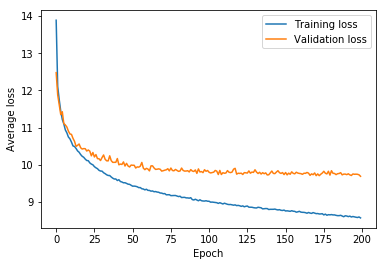

In [36]:
# Average loss per epoch
ltrain_epochs = []
for epoch_list in losses_train_epochs:
  epoch_avg = sum(epoch_list) / len(train_loader)
  ltrain_epochs.append(epoch_avg)

ltest_epochs = []
for epoch_list in losses_test_epochs:
  epoch_avg = sum(epoch_list) / len(test_loader)
  ltest_epochs.append(epoch_avg)

# Print epoch achieving minimum vali loss
min_value = min(ltest_epochs)
min_index = ltest_epochs.index(min_value)

print("The lowest loss:", round(min_value,2), "is found at epoch:", min_index, "\n")

# Plot the losses over time
plt.plot(ltrain_epochs, label="Training loss")
plt.plot(ltest_epochs, label="Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Average loss')
plt.legend()
plt.show()

## See (and check) predictions

In [ ]:
import math
from statistics import mean
from sklearn.metrics import mean_squared_error

# # Make lists of predictions and actual fractions (reference)
nested_pred = best_pred # results from the epoch with the minimum loss is taken
nested_actual = actual

unnested_pred = []
for data in nested_pred:
  for batch in data:
    for timestep in batch:
      for target in range(len(timestep)):
        unnested_pred.append(timestep[target])

unnested_actual = []
for data in nested_actual:
  for batch in data:
    for timestep in batch:
      for target in range(len(timestep)):
        unnested_actual.append(timestep[target])

# These lists contain output for entire predictions 
# Now retain lists for each class
pred_class = {}
true_class = {}

# Initialize lists for each class in predictions
for i in range(len(targets)):
  pred_class[f'{targets[i]}'] = unnested_pred[i::len(targets)]

# Initialize lists for each class in reference data
for i in range(len(targets)):
  true_class[f'{targets[i]}'] = unnested_actual[i::len(targets)]

RMSEavg = 0
MAEavg = 0

# Plot the lists as graphs

# Loop through the data and plot the actual and predicted values
for i in range(len(targets)):
    # Get the data for the current class
    actual = true_class[f'{targets[i]}']
    predicted = pred_class[f'{targets[i]}']

    # Define the x-axis data as a range of values from 0 to the length of the data
    x = range(len(actual))

    # Create a new figure
    fig = plt.figure(i)

    # Create a figure with certain size
    fig = plt.figure(figsize=(20, 3))

    # Create axes
    ax = fig.add_subplot(1, 1, 1)

    # Plot the actual and predicted values
    ax.plot(x, actual, label='Actual')
    ax.plot(x, predicted, label='Predicted')

    # Add a legend
    ax.legend()

    # Set the title using the class name
    var_name = f'{targets[i]}'
    ax.set_title(var_name)

    # Show the figure
    plt.show()

    # Print RMSE / MAE
    rmse = mean_squared_error(predicted, actual) ** 0.5
    RMSEavg = RMSEavg + rmse
    print(f'RMSE for {var_name}: {rmse}')

    difference = [abs(predicted - actual) for predicted, actual in zip(predicted, actual)]
    mae = mean(difference)
    MAEavg = MAEavg + mae
    print(f'MAE for {var_name}: {mae}')

print("\n")
print(f'Average RMSE is {RMSEavg / len(targets)} and average MAE is {MAEavg / len(targets)}')

## Create prediction data frame and write to file

In [ ]:
# Add IDs (vali data was not shuffled so can add like this --- checked with excel!)
import pandas as pd
pred_df = validf.loc[:, ['sample_id', 'location_id', 'validation_id', 'reference_year']]

# Adds predictions to df 
for i in range(len(targets)):
  data = pred_class[f'{targets[i]}']
  pred_df[targets[i]] = data 

# Show df
pred_df.head(12)

In [32]:
pred_df.to_csv('Output/LSTM/LSTM_pred.csv')
